In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/burnout-datathon-ieeecsmuj/sample_submission.csv
/kaggle/input/burnout-datathon-ieeecsmuj/val.csv
/kaggle/input/burnout-datathon-ieeecsmuj/train.csv
/kaggle/input/burnout-datathon-ieeecsmuj/test.csv


In [2]:
# Step 1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor
import warnings
warnings.filterwarnings('ignore')

In [3]:
train = pd.read_csv('/kaggle/input/burnout-datathon-ieeecsmuj/train.csv')
test = pd.read_csv('/kaggle/input/burnout-datathon-ieeecsmuj/test.csv')
val = pd.read_csv('/kaggle/input/burnout-datathon-ieeecsmuj/val.csv')
sample_submission = pd.read_csv('/kaggle/input/burnout-datathon-ieeecsmuj/sample_submission.csv')

In [4]:

print("Train shape:", train.shape)
print("Test shape:", test.shape)
print("Validation shape:", val.shape)
print("\nTrain data preview:")
train.head()

Train shape: (1914056, 45)
Test shape: (546874, 44)
Validation shape: (273437, 45)

Train data preview:


,Unique ID,Rider_ID,category_x,Circuit_Length_km,Laps,Grid_Position,Avg_Speed_kmh,Track_Condition,Humidity_%,Tire_Compound_Front,...,air,ground,starts,finishes,with_points,podiums,wins,min_year,max_year,years_active
0,1894944,2659,Moto2,4.874,22,17,264.66,Wet,61,Hard,...,23,35,53,45,41,4,0,2018,2021,4
1,23438,5205,Moto2,3.875,24,7,177.56,Wet,77,Soft,...,12,12,27,27,22,2,1,1975,1983,8
2,939678,7392,Moto3,5.647,25,5,317.74,Dry,87,Soft,...,22,23,45,43,10,0,0,1982,1989,8
3,1196312,7894,Moto3,4.810,19,3,321.82,Wet,43,Soft,...,23,35,192,172,155,16,9,1994,2009,16
4,1033899,6163,MotoGP,5.809,25,21,239.92,Wet,47,Hard,...,22,31,175,146,132,29,17,2011,2021,11


In [5]:
column_names = train.columns
print(column_names)

Index(['Unique ID', 'Rider_ID', 'category_x', 'Circuit_Length_km', 'Laps',
       'Grid_Position', 'Avg_Speed_kmh', 'Track_Condition', 'Humidity_%',
       'Tire_Compound_Front', 'Tire_Compound_Rear', 'Penalty',
       'Championship_Points', 'Championship_Position', 'Session', 'year_x',
       'sequence', 'rider', 'team', 'bike', 'position', 'points', 'shortname',
       'circuit_name', 'rider_name', 'team_name', 'bike_name',
       'Lap_Time_Seconds', 'Corners_per_Lap',
       'Tire_Degradation_Factor_per_Lap', 'Pit_Stop_Duration_Seconds',
       'Ambient_Temperature_Celsius', 'Track_Temperature_Celsius', 'weather',
       'track', 'air', 'ground', 'starts', 'finishes', 'with_points',
       'podiums', 'wins', 'min_year', 'max_year', 'years_active'],
      dtype='object')


In [6]:
# 3.1: Check for missing values
print("\nMissing values in train:\n", train.isnull().sum())
print("\nMissing values in test:\n", test.isnull().sum())


Missing values in train:
 Unique ID                               0
Rider_ID                                0
category_x                              0
Circuit_Length_km                       0
Laps                                    0
Grid_Position                           0
Avg_Speed_kmh                           0
Track_Condition                         0
Humidity_%                              0
Tire_Compound_Front                     0
Tire_Compound_Rear                      0
Penalty                            321292
Championship_Points                     0
Championship_Position                   0
Session                                 0
year_x                                  0
sequence                                0
rider                                   0
team                                    0
bike                                    0
position                                0
points                                  0
shortname                               0
circuit

In [7]:
# 3.2: Summary statistics
print("\nSummary statistics for numerical columns:")
train.describe()


Summary statistics for numerical columns:


,Unique ID,Rider_ID,Circuit_Length_km,Laps,Grid_Position,Avg_Speed_kmh,Humidity_%,Championship_Points,Championship_Position,year_x,...,air,ground,starts,finishes,with_points,podiums,wins,min_year,max_year,years_active
count,1.914056e+06,1.914056e+06,1.914056e+06,1.914056e+06,1.914056e+06,1.914056e+06,1.914056e+06,1.914056e+06,1.914056e+06,1.914056e+06,...,1.914056e+06,1.914056e+06,1.914056e+06,1.914056e+06,1.914056e+06,1.914056e+06,1.914056e+06,1.914056e+06,1.914056e+06,1.914056e+06
mean,1.367777e+06,5.509394e+03,4.701208e+00,2.150189e+01,1.149819e+01,2.496328e+02,5.951643e+01,1.744615e+02,1.254921e+01,1.997913e+03,...,2.190190e+01,2.973457e+01,1.012372e+02,8.746167e+01,7.096455e+01,1.399721e+01,7.374099e+00,1.993047e+03,2.002509e+03,9.377671e+00
std,7.890630e+05,2.597186e+03,6.910968e-01,2.293772e+00,6.334418e+00,5.773525e+01,1.733707e+01,1.009485e+02,6.913828e+00,1.708566e+01,...,5.928275e+00,1.162753e+01,8.143524e+01,6.986620e+01,6.685675e+01,2.615523e+01,1.641622e+01,1.683261e+01,1.747976e+01,5.144729e+00
min,0.000000e+00,1.000000e+03,3.500000e+00,1.800000e+01,1.000000e+00,1.500000e+02,3.000000e+01,0.000000e+00,1.000000e+00,1.949000e+03,...,1.200000e+01,1.200000e+01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.949000e+03,1.949000e+03,1.000000e+00
25%,6.847348e+05,3.258000e+03,4.104000e+00,1.900000e+01,6.000000e+00,1.993500e+02,4.400000e+01,8.700000e+01,7.000000e+00,1.987000e+03,...,1.700000e+01,2.100000e+01,3.500000e+01,3.100000e+01,1.700000e+01,0.000000e+00,0.000000e+00,1.983000e+03,1.991000e+03,5.000000e+00
50%,1.368276e+06,5.514000e+03,4.702000e+00,2.200000e+01,1.200000e+01,2.496500e+02,6.000000e+01,1.740000e+02,1.300000e+01,2.001000e+03,...,2.100000e+01,2.900000e+01,8.500000e+01,7.400000e+01,5.300000e+01,4.000000e+00,1.000000e+00,1.996000e+03,2.007000e+03,9.000000e+00
75%,2.050815e+06,7.760000e+03,5.299000e+00,2.400000e+01,1.700000e+01,2.994600e+02,7.500000e+01,2.620000e+02,1.900000e+01,2.012000e+03,...,2.600000e+01,4.000000e+01,1.460000e+02,1.230000e+02,1.060000e+02,1.600000e+01,7.000000e+00,2.006000e+03,2.019000e+03,1.200000e+01
max,2.734366e+06,9.998000e+03,5.900000e+00,2.500000e+01,2.200000e+01,3.500000e+02,8.900000e+01,3.490000e+02,2.400000e+01,2.021000e+03,...,3.600000e+01,5.400000e+01,4.060000e+02,3.730000e+02,3.650000e+02,1.780000e+02,1.180000e+02,2.021000e+03,2.021000e+03,2.600000e+01


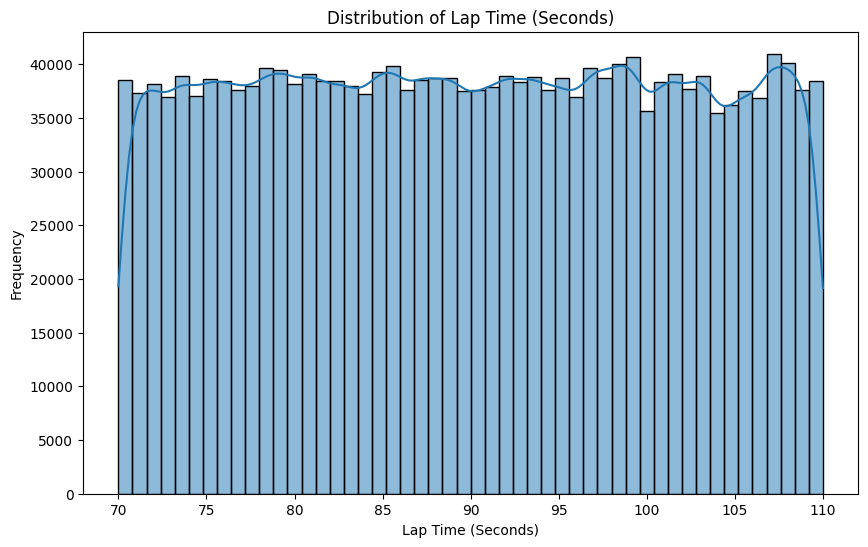

In [8]:
# 3.3: Distribution of target variable (Lap_Time_Seconds)
plt.figure(figsize=(10, 6))
sns.histplot(train['Lap_Time_Seconds'], bins=50, kde=True)
plt.title('Distribution of Lap Time (Seconds)')
plt.xlabel('Lap Time (Seconds)')
plt.ylabel('Frequency')
plt.show()


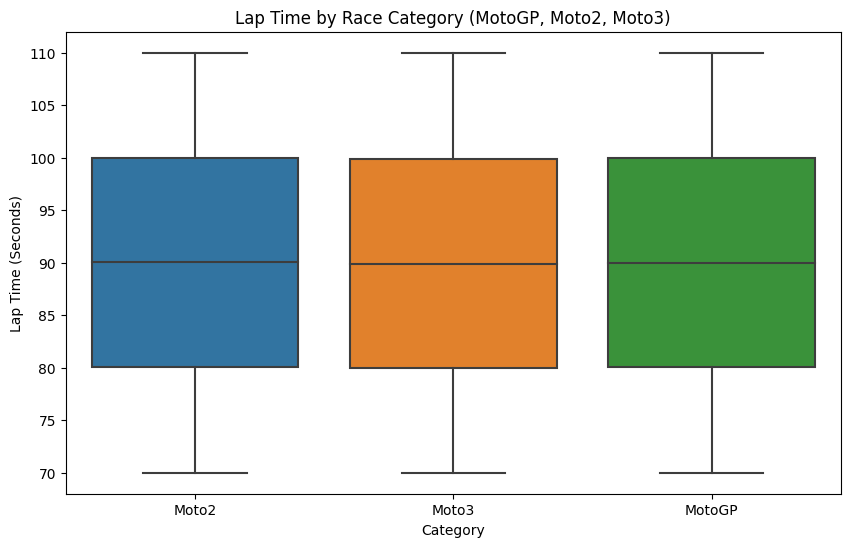

In [9]:
# 3.4: Box plot of Lap_Time_Seconds by category_x
plt.figure(figsize=(10, 6))
sns.boxplot(x='category_x', y='Lap_Time_Seconds', data=train)
plt.title('Lap Time by Race Category (MotoGP, Moto2, Moto3)')
plt.xlabel('Category')
plt.ylabel('Lap Time (Seconds)')
plt.show()


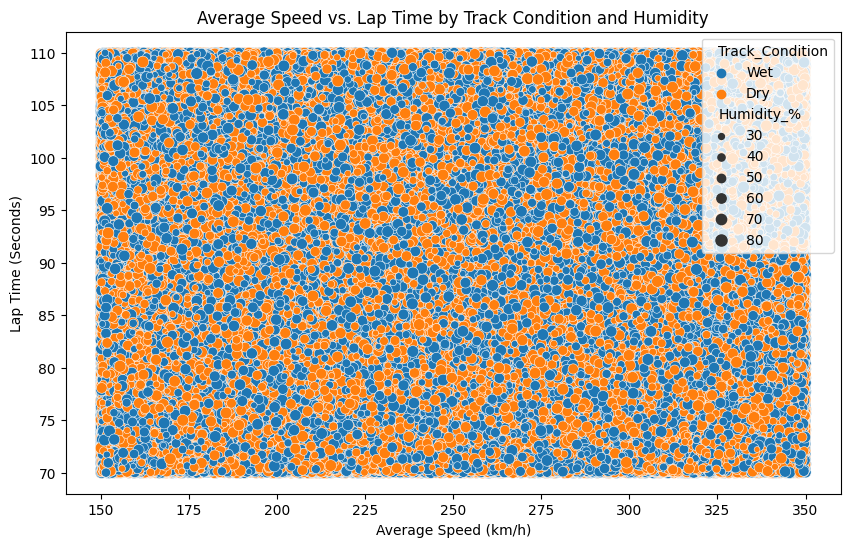

In [10]:
# 3.5: Scatter plot of Avg_Speed_kmh vs. Lap_Time_Seconds
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Avg_Speed_kmh', y='Lap_Time_Seconds', hue='Track_Condition', size='Humidity_%', data=train)
plt.title('Average Speed vs. Lap Time by Track Condition and Humidity')
plt.xlabel('Average Speed (km/h)')
plt.ylabel('Lap Time (Seconds)')
plt.show()


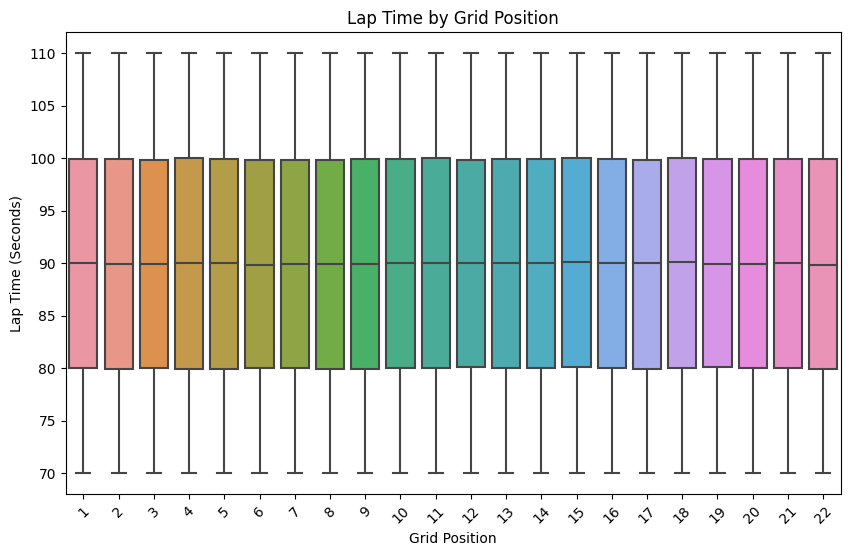

In [11]:
# 3.7: Grid_Position vs. Lap_Time_Seconds
plt.figure(figsize=(10, 6))
sns.boxplot(x='Grid_Position', y='Lap_Time_Seconds', data=train)
plt.title('Lap Time by Grid Position')
plt.xlabel('Grid Position')
plt.ylabel('Lap Time (Seconds)')
plt.xticks(rotation=45)
plt.show()

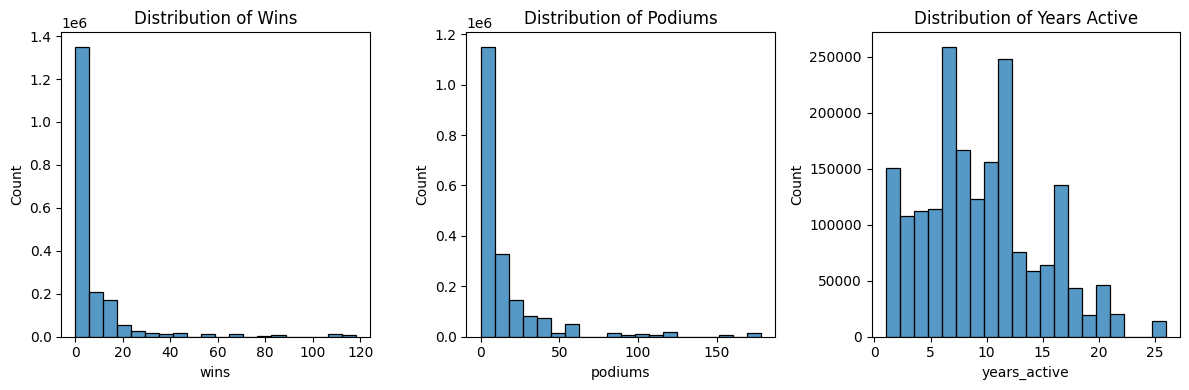

In [12]:
# 3.8: Rider performance metrics (Wins, Podiums, Years Active)
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
sns.histplot(train['wins'], bins=20)
plt.title('Distribution of Wins')
plt.subplot(1, 3, 2)
sns.histplot(train['podiums'], bins=20)
plt.title('Distribution of Podiums')
plt.subplot(1, 3, 3)
sns.histplot(train['years_active'], bins=20)
plt.title('Distribution of Years Active')
plt.tight_layout()
plt.show()

In [13]:
# Step 3: Define Column Types
# Corrected numerical_cols to include only numeric columns
numerical_cols = [
    'Circuit_Length_km', 'Laps', 'Grid_Position', 'Avg_Speed_kmh', 'Humidity_%',
    'Championship_Points', 'Championship_Position', 'year_x', 'sequence', 'position',
    'points', 'Corners_per_Lap', 'Tire_Degradation_Factor_per_Lap',
    'Pit_Stop_Duration_Seconds', 'Ambient_Temperature_Celsius',
    'Track_Temperature_Celsius', 'track', 'air', 'ground', 'starts',
    'finishes', 'with_points', 'podiums', 'wins', 'min_year', 'max_year',
    'years_active', 'Lap_Time_Seconds'
]
categorical_cols = [
    'Unique ID', 'Rider_ID', 'category_x', 'Track_Condition', 'Tire_Compound_Front',
    'Tire_Compound_Rear', 'Penalty', 'Session', 'rider', 'team', 'bike',
    'shortname', 'circuit_name', 'rider_name', 'team_name', 'bike_name', 'weather'
]

# Verify columns exist and are numeric/categorical
missing_cols = [col for col in numerical_cols + categorical_cols if col not in train.columns]
if missing_cols:
    print(f"\nWarning: Missing columns: {missing_cols}")

# Check data types to ensure numerical_cols are numeric
print("\nData types of numerical_cols:")
for col in numerical_cols:
    if col in train.columns:
        print(f"{col}: {train[col].dtype}")


Data types of numerical_cols:
Circuit_Length_km: float64
Laps: int64
Grid_Position: int64
Avg_Speed_kmh: float64
Humidity_%: int64
Championship_Points: int64
Championship_Position: int64
year_x: int64
sequence: int64
position: int64
points: float64
Corners_per_Lap: int64
Tire_Degradation_Factor_per_Lap: float64
Pit_Stop_Duration_Seconds: float64
Ambient_Temperature_Celsius: float64
Track_Temperature_Celsius: float64
track: object
air: int64
ground: int64
starts: int64
finishes: int64
with_points: int64
podiums: int64
wins: int64
min_year: int64
max_year: int64
years_active: int64
Lap_Time_Seconds: float64


In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

In [15]:
# Step 4: Data Preprocessing
# 4.1: Encode Track_Condition numerically for feature engineering
le = LabelEncoder()
train['Track_Condition_Encoded'] = le.fit_transform(train['Track_Condition'].astype(str))
test['Track_Condition_Encoded'] = le.transform(test['Track_Condition'].astype(str))

# 4.2: Impute missing numerical values with median
# Only include columns that exist and are numeric
valid_numerical_cols = [col for col in numerical_cols[:-1] if col in train.columns and train[col].dtype in ['int64', 'float64']]
train[valid_numerical_cols] = train[valid_numerical_cols].fillna(train[valid_numerical_cols].median())
test[valid_numerical_cols] = test[valid_numerical_cols].fillna(test[valid_numerical_cols].median())

# 4.3: Set categorical variables as category type for LightGBM
for col in [c for c in categorical_cols if c in train.columns and c != 'Track_Condition']:
    train[col] = train[col].astype('category')
    test[col] = test[col].astype('category')

# 4.4: Handle outliers in Lap_Time_Seconds
Q1 = train['Lap_Time_Seconds'].quantile(0.25)
Q3 = train['Lap_Time_Seconds'].quantile(0.75)
IQR = Q3 - Q1
train = train[(train['Lap_Time_Seconds'] >= Q1 - 1.5 * IQR) & (train['Lap_Time_Seconds'] <= Q3 + 1.5 * IQR)]

In [16]:
# Step 6: Feature Engineering
# Create copies to avoid SettingWithCopyWarning
# Drop all categorical columns except those needed as categorical features or encoded
cat_features_to_keep = ['category_x', 'Tire_Compound_Front', 'Tire_Compound_Rear', 'Penalty', 'Session', 'rider', 'team', 'bike', 'shortname', 'circuit_name', 'rider_name', 'team_name', 'bike_name', 'track']
X_train = train.drop(['Lap_Time_Seconds', 'Track_Condition', 'Unique ID', 'weather'] + [col for col in categorical_cols if col not in cat_features_to_keep and col in train.columns], axis=1).copy()
y_train = train['Lap_Time_Seconds'].copy()
X_test = test.drop(['Track_Condition', 'Unique ID', 'weather'] + [col for col in categorical_cols if col not in cat_features_to_keep and col in test.columns], axis=1).copy()

# Split train into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Feature 1: Speed Degradation
X_train['Speed_Degradation'] = X_train['Avg_Speed_kmh'] * X_train['Tire_Degradation_Factor_per_Lap']
X_val['Speed_Degradation'] = X_val['Avg_Speed_kmh'] * X_val['Tire_Degradation_Factor_per_Lap']
X_test['Speed_Degradation'] = X_test['Avg_Speed_kmh'] * X_test['Tire_Degradation_Factor_per_Lap']

# Feature 2: Corners per Kilometer
X_train['Corners_per_Km'] = X_train['Corners_per_Lap'] / (X_train['Circuit_Length_km'] + 1e-3)
X_val['Corners_per_Km'] = X_val['Corners_per_Lap'] / (X_val['Circuit_Length_km'] + 1e-3)
X_test['Corners_per_Km'] = X_test['Corners_per_Lap'] / (X_test['Circuit_Length_km'] + 1e-3)

# Feature 3: Rider Experience Score
X_train['Experience_Score'] = X_train['years_active'] * (X_train['wins'] + X_train['podiums'] + 0.5 * X_train['with_points'])
X_val['Experience_Score'] = X_val['years_active'] * (X_val['wins'] + X_val['podiums'] + 0.5 * X_val['with_points'])
X_test['Experience_Score'] = X_test['years_active'] * (X_test['wins'] + X_test['podiums'] + 0.5 * X_test['with_points'])

# Feature 4: Track Complexity
X_train['Track_Complexity'] = X_train['Corners_per_Lap'] * X_train['Circuit_Length_km'] * (1 + X_train['Humidity_%'] / 100)
X_val['Track_Complexity'] = X_val['Corners_per_Lap'] * X_val['Circuit_Length_km'] * (1 + X_val['Humidity_%'] / 100)
X_test['Track_Complexity'] = X_test['Corners_per_Lap'] * X_test['Circuit_Length_km'] * (1 + X_test['Humidity_%'] / 100)

# Feature 5: Temperature Interaction
X_train['Temp_Interaction'] = X_train['Track_Temperature_Celsius'] * X_train['Track_Condition_Encoded']
X_val['Temp_Interaction'] = X_val['Track_Temperature_Celsius'] * X_val['Track_Condition_Encoded']
X_test['Temp_Interaction'] = X_test['Track_Temperature_Celsius'] * X_test['Track_Condition_Encoded']

# Feature 6: Tire Match
X_train['Tire_Match'] = (X_train['Tire_Compound_Front'] == X_train['Tire_Compound_Rear']).astype(int)
X_val['Tire_Match'] = (X_val['Tire_Compound_Front'] == X_val['Tire_Compound_Rear']).astype(int)
X_test['Tire_Match'] = (X_test['Tire_Compound_Front'] == X_test['Tire_Compound_Rear']).astype(int)

# Feature 7: Pit Stop Effect
X_train['Pit_Stop_Effect'] = X_train['Pit_Stop_Duration_Seconds'] / (X_train['Laps'] + 1e-3)
X_val['Pit_Stop_Effect'] = X_val['Pit_Stop_Duration_Seconds'] / (X_val['Laps'] + 1e-3)
X_test['Pit_Stop_Effect'] = X_test['Pit_Stop_Duration_Seconds'] / (X_test['Laps'] + 1e-3)

# Feature 8: Grid Position Speed
X_train['Grid_Position_Speed'] = X_train['Grid_Position'] / (X_train['Avg_Speed_kmh'] + 1e-3)
X_val['Grid_Position_Speed'] = X_val['Grid_Position'] / (X_val['Avg_Speed_kmh'] + 1e-3)
X_test['Grid_Position_Speed'] = X_test['Grid_Position'] / (X_test['Avg_Speed_kmh'] + 1e-3)

In [17]:
# Step 7: Model Training with LightGBM
# Define categorical features for LightGBM
import lightgbm as lgb
cat_features = [col for col in ['category_x', 'Tire_Compound_Front', 'Tire_Compound_Rear', 'Penalty', 'Session', 'rider', 'team', 'bike', 'shortname', 'circuit_name', 'rider_name', 'team_name', 'bike_name', 'track'] if col in X_train.columns]

# Ensure categorical features are set to 'category' dtype
for col in cat_features:
    if col in X_train.columns:
        X_train[col] = X_train[col].astype('category')
        X_val[col] = X_val[col].astype('category')
        X_test[col] = X_test[col].astype('category')

# Debug: Check dtypes before fitting
print("\nX_train dtypes before model.fit():\n", X_train.dtypes)
non_numeric_cols = X_train.select_dtypes(exclude=['int64', 'float64', 'bool', 'category']).columns
if len(non_numeric_cols) > 0:
    print(f"\nWarning: Non-numeric columns found: {non_numeric_cols}")

model = LGBMRegressor(
    n_estimators=2000,
    learning_rate=0.025,
    max_depth=12,
    num_leaves=100,
    subsample=0.85,
    colsample_bytree=0.8,
    reg_alpha=1.5,
    reg_lambda=2.0,
    random_state=42,
    verbosity=100
)

# Train with early stopping using callback
model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    eval_metric='rmse',
    categorical_feature=cat_features,
    callbacks=[lgb.early_stopping(stopping_rounds=100, verbose=True)]
)


X_train dtypes before model.fit():
 category_x                         category
Circuit_Length_km                   float64
Laps                                  int64
Grid_Position                         int64
Avg_Speed_kmh                       float64
Humidity_%                            int64
Tire_Compound_Front                category
Tire_Compound_Rear                 category
Penalty                            category
Championship_Points                   int64
Championship_Position                 int64
Session                            category
year_x                                int64
sequence                              int64
rider                              category
team                               category
bike                               category
position                              int64
points                              float64
shortname                          category
circuit_name                       category
rider_name                         cate

LGBMRegressor(colsample_bytree=0.8, learning_rate=0.025, max_depth=12,
              n_estimators=2000, num_leaves=100, random_state=42, reg_alpha=1.5,
              reg_lambda=2.0, subsample=0.85, verbosity=100)


Validation RMSE: 4.767179365315824


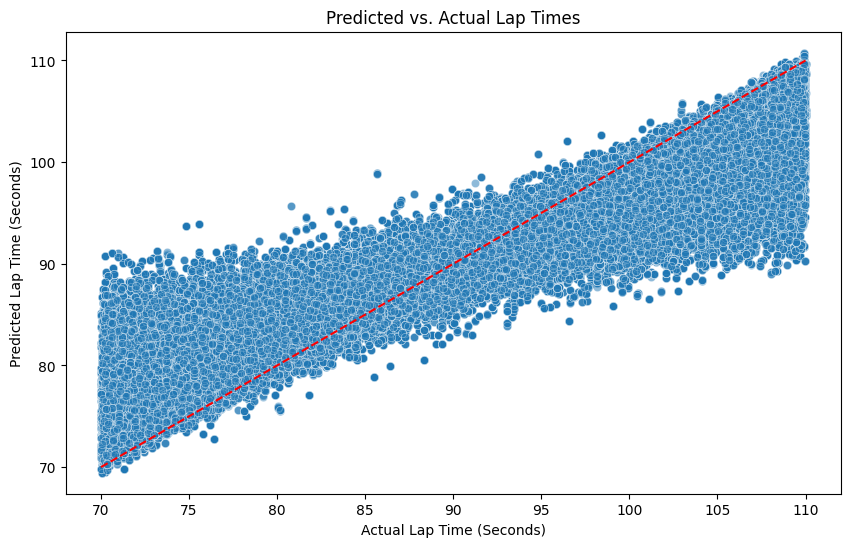

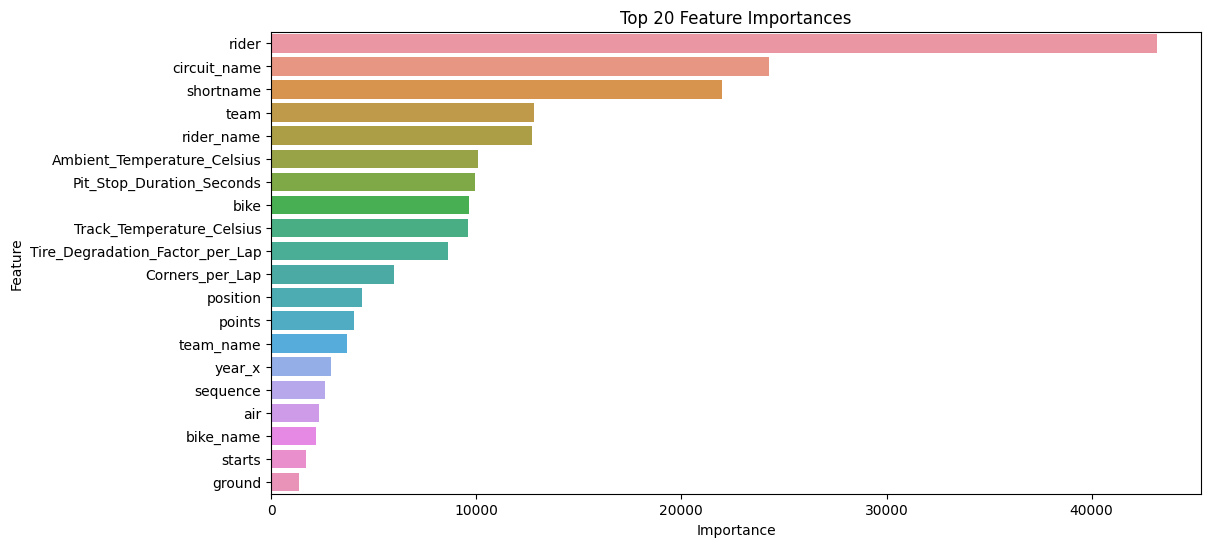

In [18]:
# Step 8: Evaluate Model
val_preds = model.predict(X_val)
rmse = mean_squared_error(y_val, val_preds, squared=False)
print("\nValidation RMSE:", rmse)

# Scatter plot of predicted vs. actual lap times
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_val, y=val_preds, alpha=0.5)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
plt.title('Predicted vs. Actual Lap Times')
plt.xlabel('Actual Lap Time (Seconds)')
plt.ylabel('Predicted Lap Time (Seconds)')
plt.show()

# Step 9: Feature Importance Plot
importances = model.feature_importances_
features = pd.Series(importances, index=X_train.columns).sort_values(ascending=False)
plt.figure(figsize=(12, 6))
sns.barplot(x=features[:20], y=features.index[:20])
plt.title('Top 20 Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()



In [19]:
# Step 10: Generate Test Predictions
test_preds = model.predict(X_test)
# Round Lap_Time_Seconds to 3 decimal places
test_preds_rounded = np.round(test_preds, 3)
submission = pd.DataFrame({
    'Unique ID': test['Unique ID'],  # Use original test to ensure correct IDs
    'Lap_Time_Seconds': test_preds_rounded
})
submission.to_csv('solution.csv', index=False)
print("Submission file created: solution.csv")
# Verify submission
submission_check = pd.read_csv('solution.csv')
print("Submission preview:\n", submission_check.head())

Submission file created: solution.csv
Submission preview:
    Unique ID  Lap_Time_Seconds
0     288307            88.436
1     704288            95.735
2     951491            90.344
3    2591721           105.463
4    1202653            97.857
